In [194]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


### Extract PRECT anomalies time series over Seattle Metro Area (TARGET)

In [195]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [196]:
imp.reload(utils)
imp.reload(filemethods)
imp.reload(data_generator)

# data = ClimateData(
#     config["databuilder"], 
#     expname = config["expname"],
#     seed=seed,
#     data_dir = config["data_dir"], 
#     figure_dir=config["figure_dir"],
#     target_only = True, 
#     fetch=False,
#     verbose=False
# )

<module 'databuilder.data_generator' from '/Users/C830793391/Documents/Research/E3SM/databuilder/data_generator.py'>

In [107]:
# d_train, d_val, d_test = data.fetch_data()

In [108]:
# d_train["x"][500:540]

In [109]:
# import pickle
# import gzip

# target_PRECT_savename1 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename1 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename1, "wb") as fp:
#     pickle.dump(d_train, fp)

# target_PRECT_savename2 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename2 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename2, "wb") as fp:
#     pickle.dump(d_val, fp)

# target_PRECT_savename3 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename3 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename3, "wb") as fp:
#     pickle.dump(d_test, fp)

Process + Pickle Inputs and Targets

In [110]:
# s_dict_train, s_dict_val, s_dict_test = multi_input_data_organizer(config, MJO = True, ENSO = True, other = False)

In [111]:
# s_dict_train["y"][500:540]

In [147]:
s_dict_savename1 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_train.pkl'
# # with gzip.open(s_dict_savename1, "wb") as fp:
# #     pickle.dump(s_dict_train, fp)

# s_dict_savename2 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_val.pkl'
# # with gzip.open(s_dict_savename2, "wb") as fp:
# #     pickle.dump(s_dict_val, fp)

# s_dict_savename3 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
# # with gzip.open(s_dict_savename3, "wb") as fp:
# #     pickle.dump(s_dict_test, fp)

with gzip.open(s_dict_savename1, "rb") as obj1:
    train_dat = pickle.load(obj1)
obj1.close()

# with gzip.open(s_dict_savename2, "rb") as obj2:
#     val_dat = pickle.load(obj2)
# obj2.close()

# with gzip.open(s_dict_savename3, "rb") as obj3:
#     test_dat = pickle.load(obj3)
# obj3.close()

### Try Random Gaussian Inputs and Gaussian Target: 

In [197]:
# # random inputs of 3 numbers as ["x"] and random gaussian target as ["y"]
# rng = np.random.default_rng()
# rand_input_long = rng.standard_normal(size = (train_dat["x"].shape[0]*9, 1))

# rand_inputs1 = np.zeros((train_dat["x"].shape[0], 3))
# rand_inputs2 = np.zeros((train_dat["x"].shape[0], 3))
# rand_inputs3 = np.zeros((train_dat["x"].shape[0], 3))

# for i in range(3):
#     rand_inputs1[:, i] = rand_input_long[i*train_dat["x"].shape[0]:(i+1)*train_dat["x"].shape[0], 0]
#     rand_inputs2[:, i] = rand_input_long[(i+3)*train_dat["x"].shape[0]:(i+4)*train_dat["x"].shape[0], 0]
#     rand_inputs3[:, i] = rand_input_long[(i+6)*train_dat["x"].shape[0]:(i+7)*train_dat["x"].shape[0], 0]

# rand_target_long = rng.standard_normal(size = (train_dat["y"].shape[0]*9, 1))
# rand_target1 = np.zeros(train_dat["y"].shape[0])
# rand_target2 = np.zeros(train_dat["y"].shape[0])
# rand_target3 = np.zeros(train_dat["y"].shape[0])

# for i in range(3):
#     rand_target1 = rand_target_long[0:(1)*train_dat["y"].shape[0]][0]
#     rand_target2 = rand_target_long[(1)*train_dat["y"].shape[0]:(2)*train_dat["y"].shape[0]][0]
#     rand_target3 = rand_target_long[(2)*train_dat["y"].shape[0]:(3)*train_dat["y"].shape[0]][0]

# randdict_train = {"x": rand_inputs1, "y": rand_target1[0]}
# randdict_val = {"x": rand_inputs2, "y": rand_target2[0]}
# randdict_test = {"x": rand_inputs3, "y": rand_target3[0]}

# with gzip.open('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_randdict_train.pkl', "wb") as fp:
#     pickle.dump(randdict_train, fp)

# with gzip.open('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_randdict_val.pkl', "wb") as fp:
#     pickle.dump(randdict_val, fp)

# with gzip.open('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_randdict_test.pkl', "wb") as fp:
#     pickle.dump(randdict_test, fp)

with  gzip.open('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_randdict_train.pkl', "rb") as obj1:
    train_dat = pickle.load(obj1)
with  gzip.open('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_randdict_val.pkl', "rb") as obj2:
    val_dat = pickle.load(obj2)
with gzip.open('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_randdict_test.pkl', "rb") as obj3:
    test_dat = pickle.load(obj3)

In [198]:
test_dat["y"][500:530]

array([[ 1.11937791e+00],
       [-9.33275025e-01],
       [-1.07415600e+00],
       [-4.05083054e-01],
       [ 7.79372168e-01],
       [-4.83803862e-01],
       [ 2.01249443e-01],
       [-1.26007853e+00],
       [-9.12939593e-01],
       [ 2.19206818e+00],
       [-7.62123184e-01],
       [ 7.64903863e-01],
       [-7.19411739e-01],
       [ 1.66409300e+00],
       [ 4.38435442e-02],
       [ 1.33478112e-03],
       [-2.14667623e+00],
       [-8.55672810e-01],
       [-1.37944280e-01],
       [-1.15446800e+00],
       [-1.97450156e-01],
       [ 7.10030851e-01],
       [-1.06358539e+00],
       [ 6.23851115e-01],
       [ 2.40962663e-01],
       [ 7.10829816e-01],
       [-9.24549585e-01],
       [-6.55033377e-01],
       [ 1.41855174e+00],
       [-9.98912487e-01]])

In [186]:
print(np.isnan(train_dat["x"][121:-32]).any())
print(np.isnan(val_dat["x"][121:-32]).any())
print(np.isnan(test_dat["x"][121:-32]).any())

print(np.isnan(train_dat["y"][121:-32]).any())
print(np.isnan(val_dat["y"][121:-32]).any())
print(np.isnan(test_dat["y"][121:-32]).any())

False
False
False
False
False
False


Retrieve Data: 


In [190]:
# Setup the Data
# front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
# back_cutoff = config["databuilder"]["back_cutoff"]  # remove back nans 

front_cutoff_rand = 20000
back_cutoff_rand = 20000

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_randdict_train.pkl", front_cutoff_rand, back_cutoff_rand)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_randdict_val.pkl", front_cutoff_rand, back_cutoff_rand)
testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_randdict_test.pkl", front_cutoff_rand, back_cutoff_rand)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

X1 shape: (20211, 3)
Target shape: (20211, 1)
X1 shape: (20211, 3)
Target shape: (20211, 1)
X1 shape: (20211, 3)
Target shape: (20211, 1)


Model Setup

In [199]:
# Setup the Model
model = TorchModel(
    config=config["arch"],
    target_mean=trainset.target.mean(axis=0),
    target_std=trainset.target.std(axis=0),
)
model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

somwhere device = cpu


In [200]:
# # Visualize the model
torchinfo.summary(
    model,
    [   trainset.input[: config["data_loader"]["batch_size"]].shape ],
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

# Train the Model
model.to(device)
trainer.fit()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [64, 3]                   [64, 4]                   62
├─Linear: 1-1                            [64, 3]                   [64, 6]                   24
├─Linear: 1-2                            [64, 6]                   [64, 4]                   28
Total params: 114
Trainable params: 109
Non-trainable params: 5
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
Epoch   0/4000
  0.5s - loss: 1.62991 - val_loss: 1.62492
Epoch   1/4000
  0.5s - loss: 1.62445 - val_loss: 1.62001
Epoch   2/4000
  0.5s - loss: 1.62001 - val_loss: 1.61517
Epoch   3/4000
  0.5s - loss: 1.61534 - val_loss: 1.61046
Epoch   4/4000
  0.5s - loss: 1.60921 - val_loss: 1.60597
Epoch   5/4000
  0.5s - loss: 1.60573 - val_loss: 1.60151
Epoch   6/4000
  0.5s - loss: 1.60076 - val_loss: 1.59714


In [201]:
# Save the Model
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_rand_inputs_target.pth'
torch.save(model.state_dict(), path)

In [202]:
# Load the Model
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_rand_inputs_target.pth'
model = TorchModel(config=config["arch"])
model.load_state_dict(torch.load(path))
model.eval()

TorchModel(
  (layer1): Linear(in_features=3, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=6, bias=True)
  (final): Linear(in_features=6, out_features=4, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (output_mu): Linear(in_features=4, out_features=1, bias=True)
  (output_sigma): Linear(in_features=4, out_features=1, bias=True)
  (output_gamma): Linear(in_features=4, out_features=1, bias=True)
  (output_tau): Linear(in_features=4, out_features=1, bias=True)
)

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


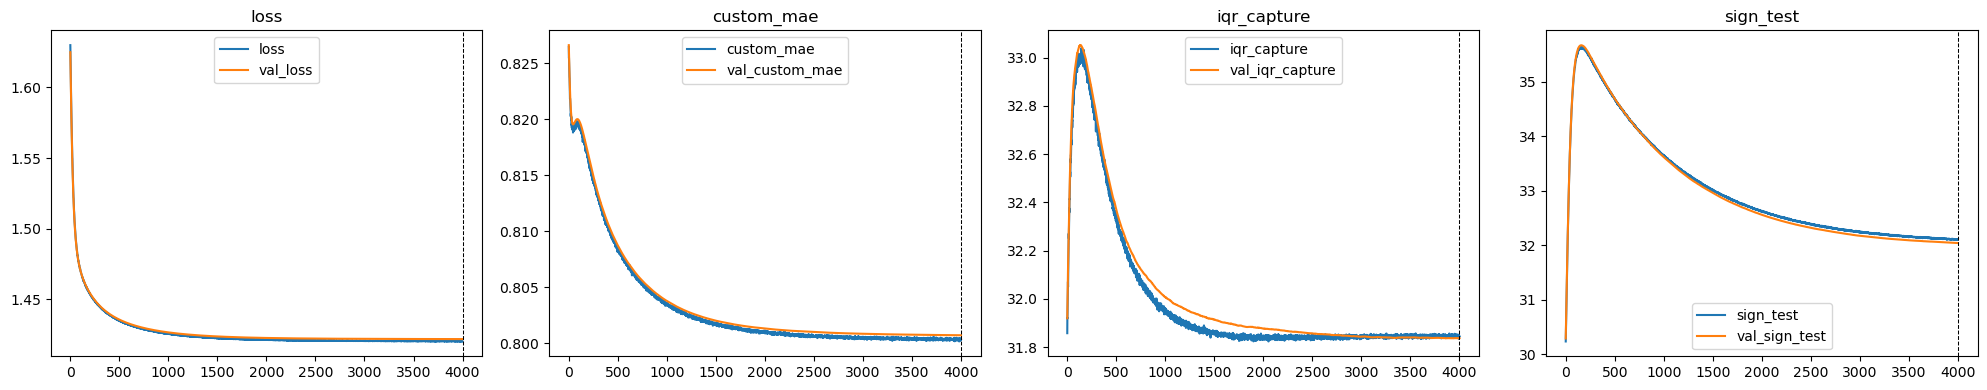

In [203]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
       x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.savefig('/Users/C830793391/Documents/Research/E3SM/saved/figures/exp006_rand_inputs_targets.png')
plt.show()

Plot Predictions Against Climatology: 

In [204]:
with torch.inference_mode():
    print(device)
    output_RERUN = model.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters
output_RERUN[:20]

cpu


array([[ 3.1063095e-02,  9.9895304e-01, -1.9499151e-02,  1.0000000e+00],
       [-4.2832792e-03,  9.9966931e-01,  3.2679997e-03,  1.0000000e+00],
       [-1.1971711e-01,  1.0009056e+00,  7.3695123e-02,  1.0000000e+00],
       [ 1.4173165e-02,  9.9952996e-01, -7.7867303e-03,  1.0000000e+00],
       [ 3.2774419e-02,  9.9960768e-01, -1.8145436e-02,  1.0000000e+00],
       [-1.9922912e-02,  9.9989003e-01,  1.3004766e-02,  1.0000000e+00],
       [ 5.2478030e-02,  9.9929047e-01, -3.0550370e-02,  1.0000000e+00],
       [-7.0567384e-02,  1.0000798e+00,  4.2646661e-02,  1.0000000e+00],
       [ 8.9062005e-04,  9.9978495e-01,  7.2406046e-04,  1.0000000e+00],
       [-1.1345373e-01,  1.0009238e+00,  7.0169255e-02,  1.0000000e+00],
       [-3.5830140e-03,  9.9978232e-01,  3.2676756e-03,  1.0000000e+00],
       [ 5.4153696e-02,  9.9902827e-01, -3.2439902e-02,  1.0000000e+00],
       [-8.5637696e-02,  1.0005895e+00,  5.3081155e-02,  1.0000000e+00],
       [-1.7417513e-02,  9.9984723e-01,  1.1414192e

In [205]:
# Save Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_rand_inputs_target.pkl'
with gzip.open(model_output_pred, "wb") as fp:
    pickle.dump(output_RERUN, fp)

In [206]:
# Open Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_rand_inputs_target.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output_noReLU = pickle.load(obj1)

In [124]:
# from shash.shash_torch import Shash
# # params = np.zeros((2,4))
# # # mu = 0; sigma=1., gamma=0, tau=1
# # params[:,1] = 1.
# # params[:,-1] = .003
# # s = Shash(params)
# s = Shash(output)

# x = np.arange(-14,15,.1)
# y = s.prob(x)
# np.shape(y)

# for i in (10, 200, 3000, 40305, 53):
#     plt.plot(x, y[:,i])

In [125]:
# from databuilder.climatology import deriveclimatology

# samples = [18213, 290, 6090, 17, 1998]

# #samples = np.linspace(1, 59000, 50).astype(int)

# x = np.arange(-12, 12, 0.025)
# print(x.shape)
# cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

# p = deriveclimatology(output_RERUN, cfile, samples, x, testset)
# print(p.shape)

Shash distribution calculations
shape of probability distribution RERUN: (250, 20211)
shape of probability distribution PKL: (250, 60058)
plotting


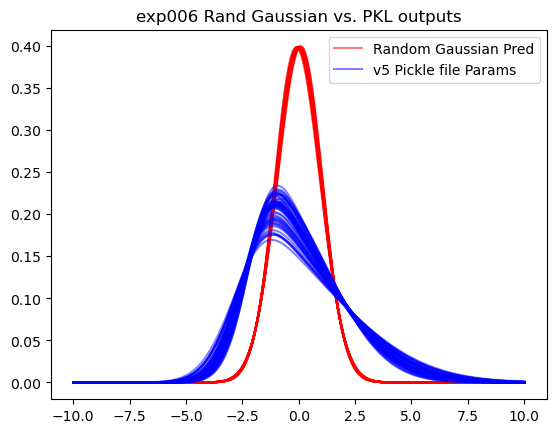

In [212]:
# imp.reload(model)
# imp.reload(model.build_model)
from shash.shash_torch import Shash

# # open v5 model: 
# print("loading model")
# path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_v5.pth'
# model_v5 = TorchModel(config=config["arch"])
# model_v5.load_state_dict(torch.load(path))
# model_v5.eval()

# print("loading model RERUN")
# path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_RERUN_noReLU.pth'
# model_RERUN = TorchModel(config=config["arch"])
# model_RERUN.load_state_dict(torch.load(path))
# model_RERUN.eval()

# --------------------------------
# print("predicting v5")
# with torch.inference_mode():
#     exp006_v5_output = model_v5.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters

# print("predicting RERUN")
# with torch.inference_mode():
#     exp006_RERUN_output = model_RERUN.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters

# open shash pickle file of climatology curves:
fn = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(fn, "rb") as obj:
    output_PKL = pickle.load(obj)

# --------------------------------
x = np.linspace(-10, 10, 250)

print("Shash distribution calculations")
dist_RERUN = Shash(output_noReLU)
p_RERUN = dist_RERUN.prob(x).numpy()
print(f"shape of probability distribution RERUN: {p_RERUN.shape}")

dist_og = Shash(output_PKL)
p_pkl = dist_og.prob(x).numpy()
print(f"shape of probability distribution PKL: {p_pkl.shape}")

# --------------------------------

samples = range(0, 20000, 400)

print("plotting")

plt.figure()
plt.plot(x, p_RERUN[:, samples], alpha=0.5, color='r')
plt.plot(x, p_RERUN[:, 5], alpha=0.5, color='r', label = 'Random Gaussian Pred')
plt.plot(x, p_pkl[:, samples], alpha=0.5, color='b')
plt.plot(x, p_pkl[:, 5], alpha=0.5, color='b', label = 'v5 Pickle file Params ')

plt.title('exp006 Rand Gaussian vs. PKL outputs')

plt.legend()

### Compare SHASH Parameter Values

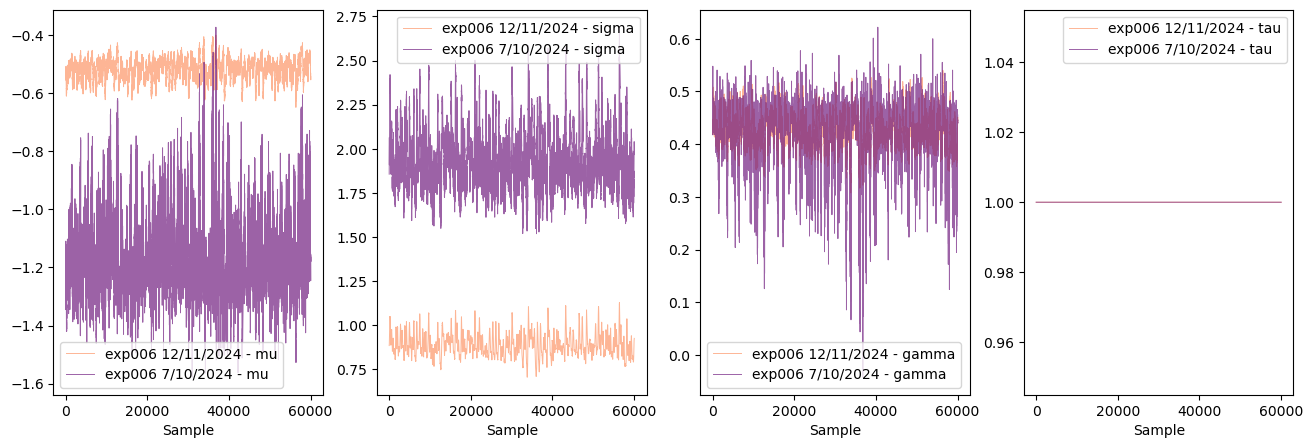

In [126]:
original_outputfn = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(original_outputfn, "rb") as obj1:
    original_output = pickle.load(obj1)


# July exp006 SHASH outputs: 
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
ax[0].plot(output_RERUN[:,0], alpha = 0.7, color = '#fd9668', label = 'exp006 12/11/2024 - mu', linewidth = 0.7)
ax[1].plot(output_RERUN[:,1], alpha = 0.7, color = '#fd9668', label = 'exp006 12/11/2024 - sigma', linewidth = 0.7)
ax[2].plot(output_RERUN[:,2], alpha = 0.7, color = '#fd9668', label = 'exp006 12/11/2024 - gamma', linewidth = 0.7)
ax[3].plot(output_RERUN[:,3], alpha = 0.7, color = '#fd9668', label = 'exp006 12/11/2024 - tau', linewidth = 0.7)

ax[0].plot(original_output[:,0], alpha = 0.7, color = '#721f81', label = 'exp006 7/10/2024 - mu', linewidth = 0.7)
ax[1].plot(original_output[:,1], alpha = 0.7, color = '#721f81', label = 'exp006 7/10/2024 - sigma', linewidth = 0.7)
ax[2].plot(original_output[:,2], alpha = 0.7, color = '#721f81', label = 'exp006 7/10/2024 - gamma', linewidth = 0.7)
ax[3].plot(original_output[:,3], alpha = 0.7, color = '#721f81', label = 'exp006 7/10/2024 - tau', linewidth = 0.7)


for i in range(4):
    ax[i].set_xlabel('Sample')
    ax[i].legend()


# Are output and original output the exact same? 
if np.array_equal(output_RERUN, original_output):
    print('Output SHASH parameters are identical')

### Compare Model v1 to Model v5 ORIGINALS

cpu
[[ 0.08212627  1.1621414  -0.21812636  1.        ]
 [-0.0617386   0.9341699   0.04183757  1.        ]
 [ 0.02283546  1.3013213  -0.13588472  1.        ]
 [-0.06355314  0.9235449   0.036328    1.        ]
 [-0.04529838  0.9191517   0.00953538  1.        ]
 [-0.05413384  0.96689856  0.01858702  1.        ]
 [-0.06152699  0.8661882   0.05140254  1.        ]
 [-0.11299258  1.0304369   0.02000946  1.        ]
 [-0.0490304   0.9498047   0.01360006  1.        ]
 [-0.08099984  1.3949733  -0.18946064  1.        ]
 [-0.0650693   0.94375014  0.03077111  1.        ]
 [ 0.0210169   0.96582913 -0.07835334  1.        ]
 [ 0.0223103   1.1842135  -0.09194888  1.        ]
 [-0.06131245  0.94851923  0.03821428  1.        ]
 [-0.08876924  0.9499385   0.02022641  1.        ]
 [-0.06246246  0.9196292   0.04192627  1.        ]
 [-0.00546708  1.0286567  -0.1062056   1.        ]
 [-0.01332279  1.0602392  -0.03346889  1.        ]
 [-0.05844606  0.9410265   0.04122438  1.        ]
 [-0.08658807  0.9369164  -

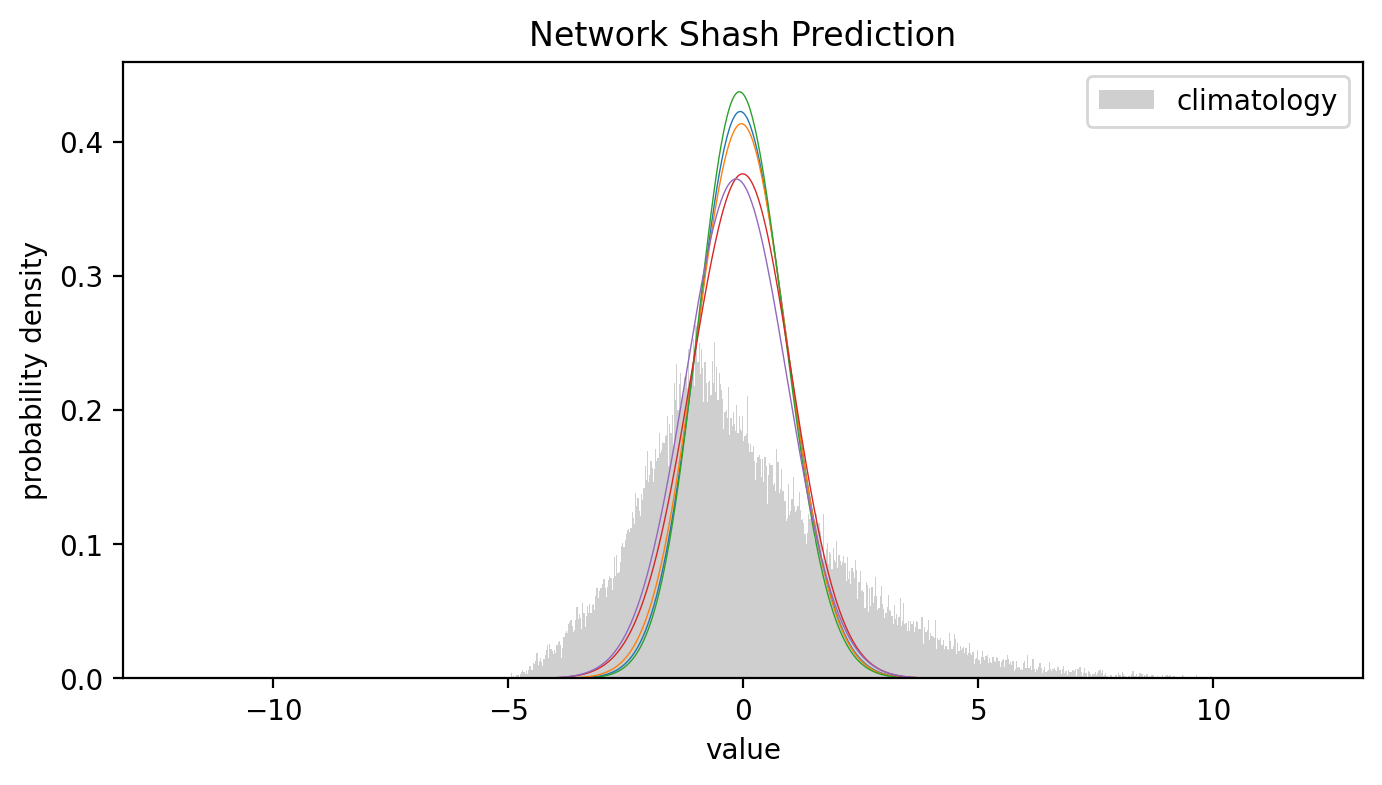

(960, 20211)


In [214]:
from databuilder.climatology import deriveclimatology

# Load the Model
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_rand_inputs_target.pth'
model_v5 = TorchModel(config=config["arch"])
model_v5.load_state_dict(torch.load(path))
model_v5.eval()

with torch.inference_mode():
    print(device)
    exp006_v5_output = model_v5.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters
print(exp006_v5_output[:20])

samples = [18213, 290, 6090, 17, 1998]

#samples = np.linspace(1, 59000, 50).astype(int)

x = np.arange(-12, 12, 0.025)
print(x.shape)
cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

p = deriveclimatology(exp006_v5_output, cfile, samples, x, testset)
print(p.shape)

## Gaussian Check with my Plotting Code: 

In [ ]:
from databuilder.climatology import deriveclimatology

gaussian_shash = np.array([0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0])

x = np.arange(-12, 12, 0.025)
print(x.shape)
cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

p = deriveclimatology(gaussian_shash, cfile, samples, x, testset)
print(p.shape)

## CRPS - Compare Distributions against Target / Climatology

In [128]:
from model.metric import compute_crps

crps = compute_crps(
            pred=p, y=testset, bins=x, climatology=True
        )

ImportError: cannot import name 'compute_crps' from 'model.metric' (/Users/C830793391/Documents/Research/E3SM/model/metric.py)

In [ ]:
# ----------------------------------------
# LOAD THE PREDICTIONS
predictions = file_methods.load_predictions(PREDICTIONS_DIRECTORY + model_name + "_predictions.pickle")

mu_pred, sigma_pred, gamma_pred, tau_pred = np.hsplit(predictions["pred_test"], 4)
dist = shash_tfp.Shash(mu_pred, sigma_pred, gamma_pred, tau_pred)
crps = custom_metrics.compute_crps(dist.cdf(bins).numpy(), predictions["labels_test"], bins, parametric=True)

 # ----------------------------------------
# COMPUTE BASELINES
crps_base = custom_metrics.compute_crps(
    pred=predictions["labels_train"], y=predictions["labels_test"], bins=bins, climatology=True
)